In [1]:
import pandas as pd
import numpy as np
import timeit
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
#import plotly.graph_objs as go
%matplotlib inline

In [2]:
from pandas_datareader import data as pdr

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
date_end = dt.datetime.today()
date_start = date_end - dt.timedelta(1000)

In [4]:
date_end, date_start

(datetime.datetime(2020, 6, 26, 0, 57, 42, 799217),
 datetime.datetime(2017, 9, 30, 0, 57, 42, 799217))

In [5]:
df = pdr.DataReader("AAPL", 'yahoo', date_start, date_end).reset_index()

In [6]:
df = df.loc[df['Date'].notnull()]

In [7]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2017-10-02,154.449997,152.720001,154.259995,153.809998,18698800.0,148.004257
1,2017-10-03,155.089996,153.910004,154.009995,154.479996,16230300.0,148.648956
2,2017-10-04,153.860001,152.460007,153.630005,153.479996,20163800.0,147.686707
3,2017-10-05,155.440002,154.050003,154.179993,155.389999,21283800.0,149.524597
4,2017-10-06,155.490005,154.559998,154.970001,155.300003,17407600.0,149.437988
...,...,...,...,...,...,...,...
683,2020-06-19,356.559998,345.149994,354.640015,349.720001,66119000.0,349.720001
684,2020-06-22,359.459991,351.149994,351.339996,358.869995,33861300.0,358.869995
685,2020-06-23,372.380005,362.269989,364.000000,366.529999,53038900.0,366.529999
686,2020-06-24,368.790009,358.519989,365.000000,360.059998,48081100.0,360.059998


In [8]:
df.dtypes

Date         datetime64[ns]
High                float64
Low                 float64
Open                float64
Close               float64
Volume              float64
Adj Close           float64
dtype: object

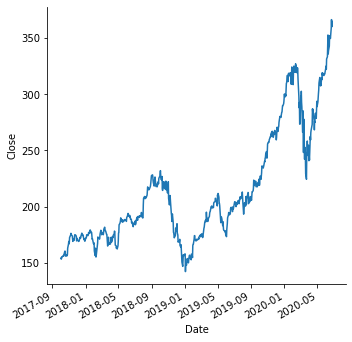

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.relplot(x='Date', y='Close', kind='line', data=df).fig.autofmt_xdate()

# preprocessing

In [10]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
scaler = MinMaxScaler(feature_range=(0, 1))
le = preprocessing.LabelEncoder()

In [11]:
df['Date encoded'] = le.fit_transform(df['Date'])

In [12]:
scaled_Close = scaler.fit_transform(df[['Close']])

In [13]:
scaled_Close = np.squeeze(scaled_Close)

In [14]:
df.values[600:, 7]

array([600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612,
       613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625,
       626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 637, 638,
       639, 640, 641, 642, 643, 644, 645, 646, 647, 648, 649, 650, 651,
       652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664,
       665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677,
       678, 679, 680, 681, 682, 683, 684, 685, 686, 687], dtype=object)

In [15]:
x_train, y_train = df.values[:600, 7], scaled_Close[:600]
x_test, y_test = df.values[600:, 7], scaled_Close[600:]

x_train, y_train = df.values[:600, 0], scaled_Close[:600]
x_test, y_test = df.values[600:, 0], scaled_Close[600:]

# split train data

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=.2)


# Reshape data in order to apply LSTML

In [17]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((480,), (480,), (88,), (88,))

In [19]:

X_train_t = x_train.reshape(x_train.shape[0], 1, 1)
X_test_t = x_test.reshape(x_test.shape[0], 1, 1)

In [20]:
X_test_t.shape, X_train_t.shape

((88, 1, 1), (480, 1, 1))

## Keras

In [120]:
from keras.models import Sequential
from keras.layers import Dense

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
import keras.backend as K 
from keras.callbacks import EarlyStopping
#import lstm, time

model = Sequential()

#model.add(Dense(50, activation='sigmoid', input_shape=(1,)))
#model.add(LSTM(30, activation='sigmoid', input_shape=(None,1)))
model.add(LSTM(30, activation='relu', input_shape=(None,1))) #rectified linear unit
model.add(Dense(1)) #, activation='linear'))

model.summary()

model.compile(optimizer='adam', loss='mse', metrics=['mape']) 
#optimizer = 'adgrad', 'adam', 'sgd'
#sgd - stochastic gradient descent
#mse - mean square error
#mape - mean absolute percentage error

#history = model.fit(x_train, y_train, batch_size=10, epochs=200, validation_data=(x_valid, y_valid))

early_stop = EarlyStopping(monitor='loss', patience=5, verbose=0)

history = model.fit(X_train_t, y_train, epochs=100, batch_size=30, verbose=1, callbacks=[early_stop])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
480/480 [==============================] - 1s 3ms/step - loss: 2452.6730 - mape: 90367416.0000
Epoch 2/100
480/480 [==============================] - 0s 115us/step - loss: 1408.5150 - mape: 79402904.0000
Epoch 3/100
480/480 [==============================] - 0s 117us/step - loss: 317.6313 - mape: 20160684.0000
Epoch 4/100
480/480 [==============================] - 0s 124us/step - loss: 38.7481 - mape: 17148666.0000
Epoch 5/100
480/480 [==============================] - 0s 126us/step - loss: 7.3891

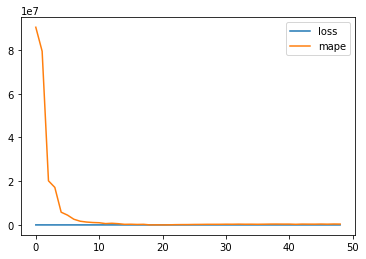

In [121]:
for name, value in history.history.items():
    plt.plot(value, label=name)
plt.legend()
plt.show()

In [122]:
## evaluate model

#results = model.evaluate(x_test, y_test)

results = model.evaluate(X_test_t, y_test)
#print('Loss: {:.6f} - MAPE: {:.6f}'.format(*results))

88/88 [==============================] - 0s 3ms/step


trainScore = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(x_test, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

In [118]:
trainScore = model.evaluate(X_train_t, y_train, verbose=0)
model.reset_states()
print('Train Score: ', trainScore)
valScore = model.evaluate(X_test_t, y_test, verbose=0)
model.reset_states()
print('Validataion Score: ', valScore)
testScore = model.evaluate(X_test_t, y_test, verbose=0)
model.reset_states()
print('Test Score: ', testScore)

Train Score:  [0.019377578049898148, 608919.6875]
Validataion Score:  [0.10248293388973582, 38.50205993652344]
Test Score:  [0.10248293388973582, 38.50205993652344]


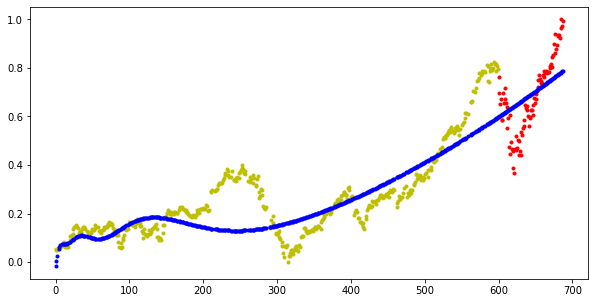

In [124]:
test_pred = model.predict(X_test_t)
train_pred = model.predict(X_train_t)
#train_pred = np.squeeze(train_pred)

plt.figure(figsize=(10, 5))
plt.plot(x_train, y_train, '.y', x_test, y_test, '.r',x_train, train_pred, '.b', x_test, test_pred, '.b')
plt.show()

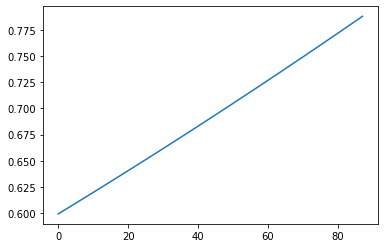

In [125]:
plt.figure()
plt.plot(test_pred)

for pred, true in zip(test_pred, y_test):
    print('Pred: {:.6f} - True: {:.6f}'.format(pred,true))

Save model

In [129]:
model_path = 'model.lstm_relu'
model.save(model_path)

from keras.models import load_model

loaded_model = load_model(model_path)

In [130]:
loaded_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30)                3840      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________
